In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# get titanic & test csv files as a DataFrame
#titanic_df = pd.read_csv("../input/train.csv")
#test_df    = pd.read_csv("../input/test.csv")

df = pd.read_csv('../data/data.csv')

titanic_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


In [4]:
print(titanic_df.info())
print("----------------------------")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB
None
----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 709 to 10
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  

In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

<Axes: xlabel='Embarked', ylabel='Survived'>

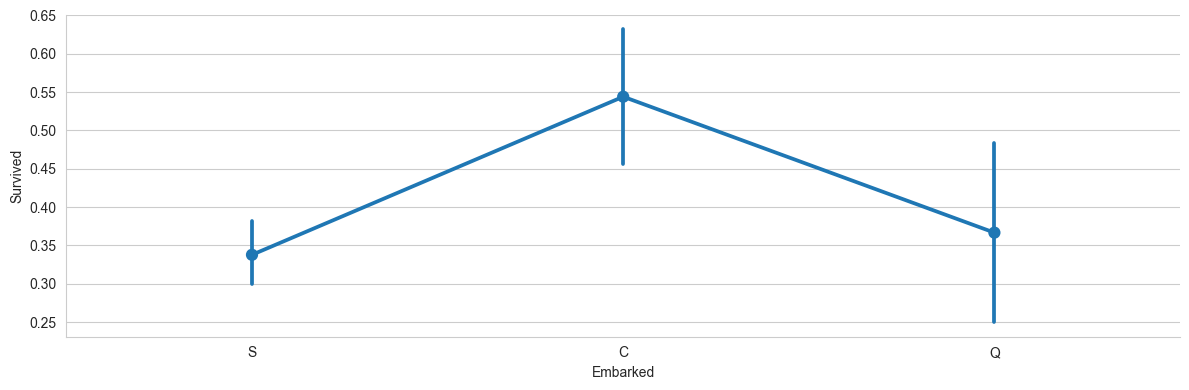

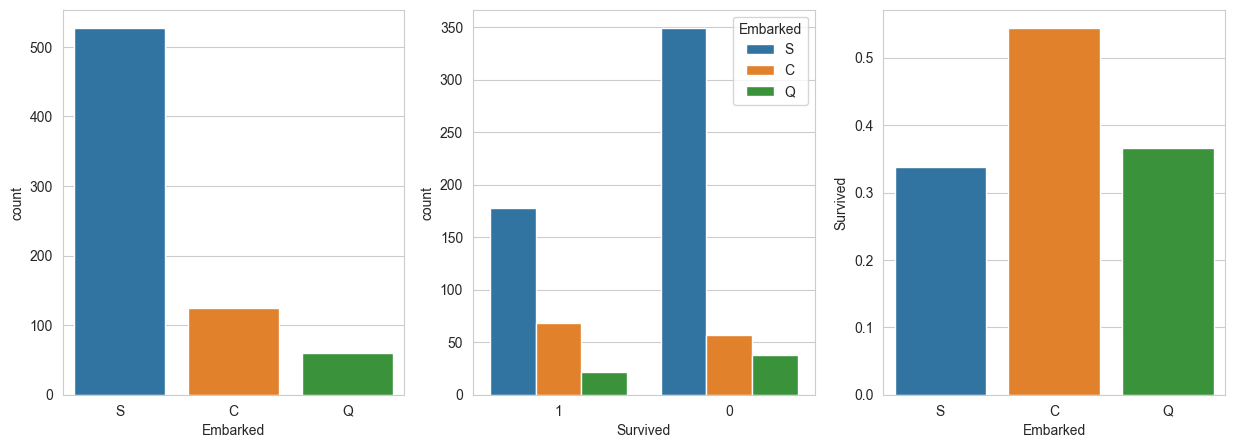

In [6]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.catplot(x='Embarked', y='Survived', data=titanic_df, kind='point', height=4, aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

In [7]:
# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

<Axes: xlabel='Survived'>

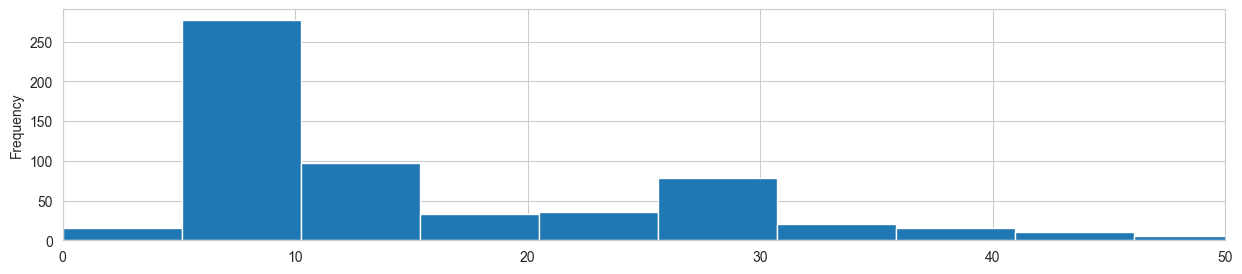

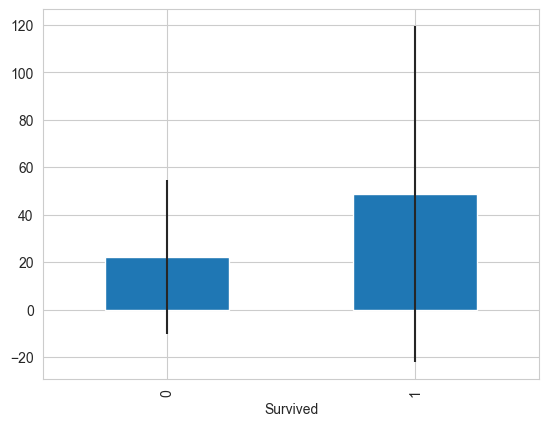

In [8]:
# Fare
# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].mean(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

In [9]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction in this simple model
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

In [10]:
# Age 
# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

/var/folders/qf/t0y3d1ps5_z2dyxppk3jdjk80000gn/T/ipykernel_97734/3639677994.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
/var/folders/qf/t0y3d1ps5_z2dyxppk3jdjk80000gn/T/ipykernel_97734/3639677994.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Age"][np.isnan(test_df["Age"])] = rand_2


In [11]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

#sns.catplot('Person',data=titanic_df,kind='count',ax=axis1)
#sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
#sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

In [12]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop(["PassengerId", "Survived"],axis=1).copy()
Y_test = test_df['Survived']

In [14]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,C,Q,Child,Female
331,1,45,0,0,28,0,0,0,0
733,2,23,0,0,13,0,0,0,0
382,3,32,0,0,7,0,0,0,0
704,3,26,1,0,7,0,0,0,0
813,3,6,4,2,31,0,0,1,0


In [13]:
 # Grid search de los mejores parámetros
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": [3, 5, 7, 9]
    }
model = RandomForestClassifier(oob_score=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(best_model)
print(grid_search.best_score_)

RandomForestClassifier(max_features=7, oob_score=True, random_state=42)
0.7991234117994681


In [55]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

/Users/Teresa/Desktop/formation/master_ue/python/modulo4/actividad2/despliegue/Proyecto_Modulo4_UEM_2021_TRAIN/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.824438202247191

In [56]:
#Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

0.6671348314606742

In [27]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=200,oob_score=True,max_features=5)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.9634831460674157

In [58]:
random_forest.get_params,random_forest.feature_importances_

(<bound method BaseEstimator.get_params of RandomForestClassifier(max_features=5, oob_score=True)>,
 array([0.09676693, 0.29239719, 0.06016982, 0.03044643, 0.18806853,
        0.02300884, 0.02079947, 0.03185799, 0.2564848 ]))

In [59]:
# Gradient Boosts
grad_boost = GradientBoostingClassifier(n_estimators=1000)
grad_boost.fit(X_train, Y_train)
Y_pred = grad_boost.predict(X_test)
grad_boost.score(X_train, Y_train)

0.9620786516853933

In [60]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Pclass,-0.906343
1,Age,-0.014648
2,SibSp,-0.391421
3,Parch,-0.184471
4,Fare,0.003055
5,C,0.419433
6,Q,0.129995
7,Child,2.462385
8,Female,2.929615


In [61]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)